In [1]:
    !pip install datasets transformers evaluate imbalanced-learn umap-learn wandb GPUtil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=9aa2457b8f4254263b6345320c2e031a69a7d8eb2c8913a981a6ee0ea4e8a5f3
  Stored in directory: /root/.cache/pip/wheels/b1/e7/99/2b32600270cf23194c9860f029d3d5db075f250bc39028c045
Successfully built GPUtil


In [2]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
from datasets import load_dataset

health_fact = load_dataset('health_fact')

Generating train split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1235 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1225 [00:00<?, ? examples/s]

Dataset health_fact downloaded and prepared to /root/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
# Filter out instances with a -1 label
health_fact['train'] = health_fact['train'].filter(lambda x: x['label'] != -1)
health_fact['validation'] = health_fact['validation'].filter(lambda x: x['label'] != -1)
health_fact['test'] = health_fact['test'].filter(lambda x: x['label'] != -1)

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [7]:
health_fact.set_format(type="pandas")
df = health_fact["train"][:]
df.head()

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,0,"Foreign Policy, PunditFact, Newt Gingrich,"
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,1,"Screening,WebMD,women's health"
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,1,"Association/Society news release,Cancer"
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,2,"Cancer,WebMD,women's health"
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,2,


In [8]:
def label_int2str(row):
    if row == -1:
        return 'invalid'
    return health_fact["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)

In [9]:
df.head()

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,label_name
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,0,"Foreign Policy, PunditFact, Newt Gingrich,",false
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,1,"Screening,WebMD,women's health",mixture
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,1,"Association/Society news release,Cancer",mixture
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,2,"Cancer,WebMD,women's health",true
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,2,,true


Text(0.5, 1.0, 'Frequency of Classes')

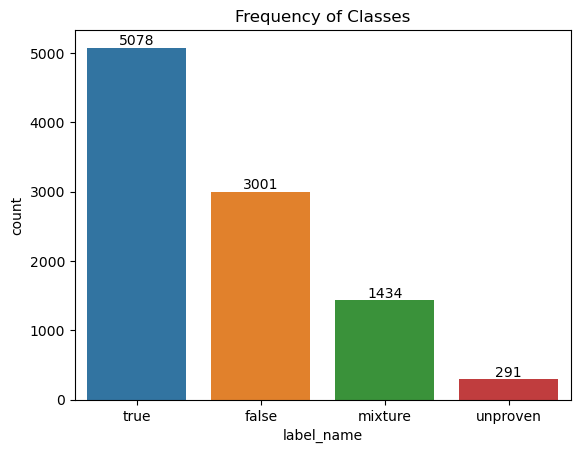

In [10]:
# df["label_name"].value_counts(ascending=True).plot.barh()

ax = sns.countplot(x='label_name', data=df, order = df['label_name'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.title("Frequency of Classes")

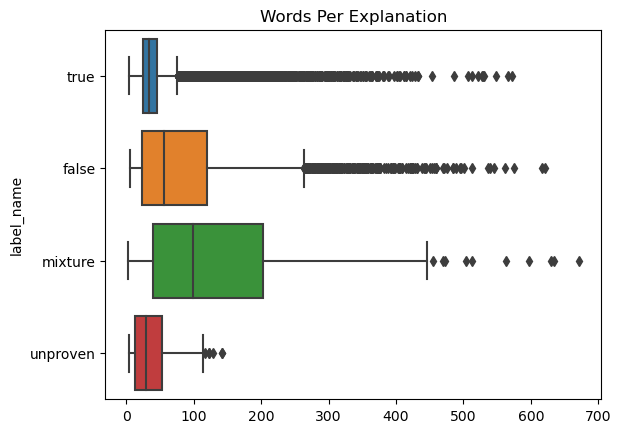

In [11]:
df['Words Per Explanation'] = df['explanation'].str.split().apply(len)
sns.boxplot(x=df['Words Per Explanation'], y=df['label_name'], data=df, order = df['label_name'].value_counts().index)
plt.title("Words Per Explanation")
plt.xlabel("")
plt.show()

In [13]:
# checkpoint = "bert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# tokenized_explanations = tokenizer(health_fact["train"]["explanation"], max_length=512, truncation=True, padding=True, return_tensors="pt")

In [10]:
health_fact.reset_format()

In [78]:
from transformers import AutoTokenizer

# model_ckpt = 'distilbert-base-uncased'
model_ckpt = 'allenai/longformer-base-4096'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [25]:

def new_column(example):
    example["summary"] = f"SUBJECTS: {example['subjects']} - CLAIM: {example['claim']} - EXPLANATION: {example['explanation']}"
    return example

health_fact = health_fact.map(new_column)
health_fact['train'][0]

  0%|          | 0/9804 [00:00<?, ?ex/s]

  0%|          | 0/1233 [00:00<?, ?ex/s]

  0%|          | 0/1214 [00:00<?, ?ex/s]

{'claim_id': '15661',
 'claim': '"The money the Clinton Foundation took from from foreign governments while Hillary Clinton was secretary of state ""is clearly illegal. … The Constitution says you can’t take this stuff."',
 'date_published': 'April 26, 2015',
 'explanation': '"Gingrich said the Clinton Foundation ""took money from from foreign governments while (Hillary Clinton) was secretary of state. It is clearly illegal. … The Constitution says you can’t take this stuff."" A clause in the Constitution does prohibit U.S. officials such as former Secretary of State Hillary Clinton from receiving gifts, or emoluments, from foreign governments. But the gifts in this case were donations from foreign governments that went to the Clinton Foundation, not Hillary Clinton. She was not part of the foundation her husband founded while she was secretary of state. Does that violate the Constitution? Some libertarian-minded constitutional law experts say it very well could. Others are skeptical. 

In [79]:
# def tokenize(batch):
#     return tokenizer(batch['explanation'], truncation=True, padding=True)

def tokenize(batch):
    return tokenizer(batch['summary'], truncation=True, padding=True)

In [80]:
health_fact_encoded = health_fact.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [28]:
print(health_fact_encoded["train"].column_names)

['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects', 'summary', 'input_ids', 'attention_mask']


In [81]:
import torch
from transformers import AutoModel

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [82]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [83]:
health_fact_encoded.set_format('torch', columns=["input_ids", "attention_mask", "label"])

In [84]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()  

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 |  0% | 45% |


In [85]:
del df

In [86]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [87]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()  

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 |  0% | 16% |


In [88]:
health_fact_hidden = health_fact_encoded.map(extract_hidden_states, batched=True, batch_size=100)

  0%|          | 0/99 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

In [89]:
import numpy as np

X_train = np.array(health_fact_hidden["train"]["hidden_state"])
X_valid = np.array(health_fact_hidden["validation"]["hidden_state"])
y_train = np.array(health_fact_hidden["train"]["label"])
y_valid = np.array(health_fact_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((9804, 768), (1214, 768))

In [90]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,2.895852,0.785735,0
1,8.520674,5.252949,1
2,8.558901,6.864313,1
3,9.121176,6.926792,2
4,7.640649,5.638116,2


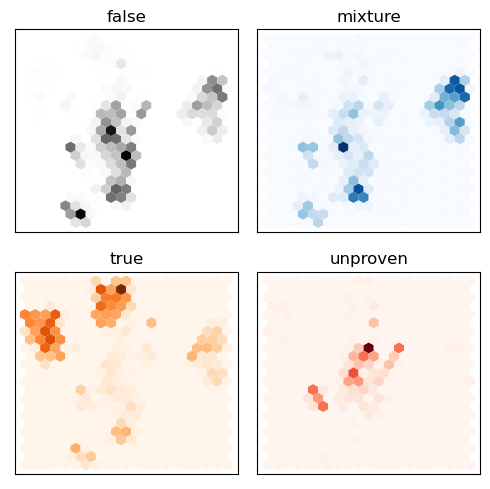

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(5,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Greens"]
labels = health_fact["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [92]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.7018121911037891

In [40]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.5181219110378913

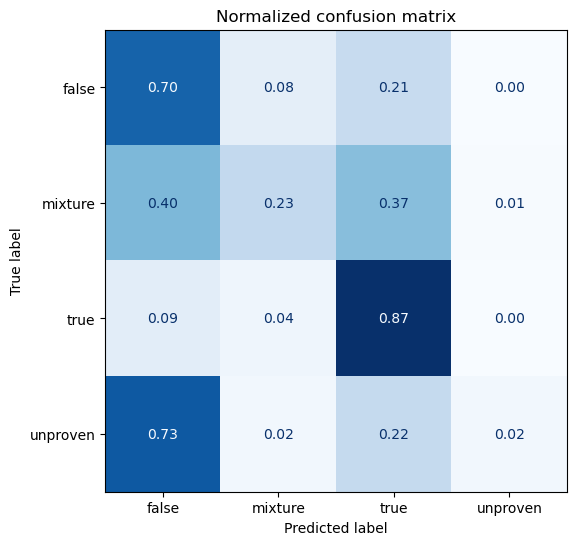

In [93]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)


In [145]:
from transformers import AutoModelForSequenceClassification

num_labels = 4
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))


In [95]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


In [141]:
from transformers import Trainer, TrainingArguments

batch_size = 2
logging_steps = len(health_fact_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-health-fact"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=4,
                                  learning_rate=1e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.0,
                                  warmup_steps=200,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  load_best_model_at_end = True,
                                  log_level="error",)


In [142]:
del model
import gc
gc.collect()
torch.cuda.empty_cache()

In [143]:
gpu_usage()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 |  0% | 28% |


In [59]:
from torch import nn
from transformers import Trainer

# ['false', 'mixture', 'true', 'unproven']
counts = [3001, 1434, 5078, 291]
weights = [ 1 - (count/sum(counts))for count in counts]

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
#         print(inputs)
        labels = inputs.get("labels")
        inputs = {k: v.to(self.args.device) for k, v in inputs.items()}
        
#         print(labels)
        # forward pass
        outputs = model(**inputs)
#         print(outputs)
        logits = outputs.get("logits")
        # compute custom loss (for 4 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

weights

[0.6939004487964096,
 0.8537331701346389,
 0.48204814361485104,
 0.9703182374541004]

In [146]:
import gc
gc.collect()
torch.cuda.empty_cache()

from transformers import Trainer
from transformers import EarlyStoppingCallback

class CustomEarlyStoppingCallback(EarlyStoppingCallback):
    def __init__(self, early_stopping_patience=3):
        super().__init__(early_stopping_patience=early_stopping_patience)

early_stopping_callback = CustomEarlyStoppingCallback(early_stopping_patience=1)
        
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=health_fact_encoded["train"],
                  eval_dataset=health_fact_encoded["validation"],
                  tokenizer=tokenizer,
                  callbacks=[early_stopping_callback],)
trainer.train();

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.879400,0.756939,0.760297,0.738893
2,0.779400,0.967213,0.772652,0.758761


In [53]:
preds_output = trainer.predict(health_fact_encoded["validation"])

In [54]:
preds_output.metrics

{'test_loss': 0.5714957118034363,
 'test_accuracy': 0.7528830313014827,
 'test_f1': 0.7379914743143585,
 'test_runtime': 11.0134,
 'test_samples_per_second': 110.229,
 'test_steps_per_second': 6.901}

In [55]:
y_preds = np.argmax(preds_output.predictions, axis=1) 

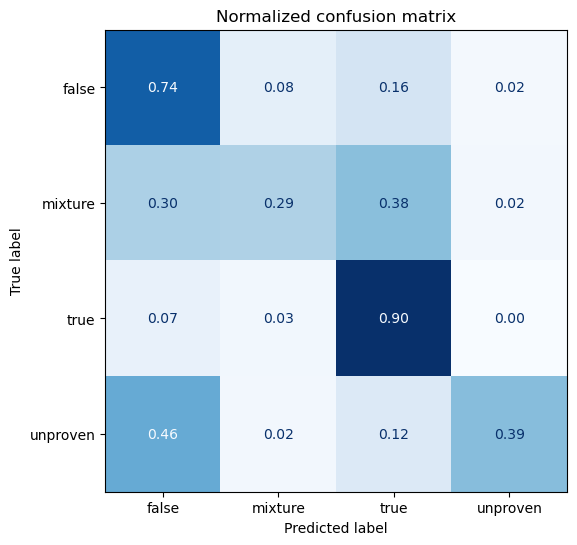

In [56]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [58]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [62]:
# Convert our dataset back to PyTorch tensors
health_fact_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
health_fact_encoded["validation"] = health_fact_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/76 [00:00<?, ?ba/s]

In [64]:
health_fact_encoded.set_format("pandas")
cols = ["summary", "label", "predicted_label", "loss"]
df_test = health_fact_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [77]:
with pd.option_context('display.max_colwidth', 2048):
    display(df_test.sort_values("loss", ascending=False).head(10))

,summary,label,predicted_label,loss
492,"SUBJECTS: Viral Phenomena, conservative post, qpolitical, reddit - CLAIM: A step-dad refused to pay for his daughter's wedding at the last minute because she allowed her biological father back into her life. - EXPLANATION: As to whether a 3 November 2015 wedding was canceled as related in the narrative, that claim was provably false. The story was lifted in its entirety from a 3 June 2013 post to Reddit’s r/offmychest titled “My step-daughter wants her “Real Dad” to give her away,” but it was subsequently reposted in subreddits devoted to misogyny and revenge tales. In the original version the wedding was scheduled for 3 August 2013 (not 3 November 2015), and it appeared the dates were revised to make the tale sound new. The user who claimed credit for originating it racked up a grand total of only four posts and was not an established Reddit user. That user returned to update the original post twice, but the story and its subsequent repetitions were still based on a single, unverified Reddit thread from 2013 (which perhaps would have more aptly been posted to this subreddit). While the narrative certainly resonated with readers, there’s no evidence it occurred outside the imagination of the individual who wrote it.",unproven,false,4.574901
903,"SUBJECTS: New Jersey, Public Health, Florida, Facebook Fact-checks, New York, Coronavirus, Facebook posts, - CLAIM: “Florida is doing over five times better” than New Jersey and New York in COVID-19 deaths per million people. - EXPLANATION: The claim is accurate on one measure — the number of COVID-19 deaths per capita for the duration of the outbreak. But the claim is that Florida is doing well now, when in fact deaths are on the rise.",false,true,4.286610
631,"SUBJECTS: Facebook Fact-checks, Coronavirus, Viral image, - CLAIM: Viral image Says Harvard scientists say the coronavirus is “spreading so fast that it will infect 70% of humanity this year.” - EXPLANATION: An epidemiologist at Harvard University projects 40%-70% of adults could catch coronavirus in the coming year.",mixture,false,4.084052
209,"SUBJECTS: P-Cure,proton therapy - CLAIM: FDA Clears P-Cure Upright Imaging Solution for Proton Therapy Enhancement - EXPLANATION: P-Cure Ltd. device We’re fully prepared to believe that there are ways to more accurately administer proton beam therapy with fewer side effects and lower costs. This release makes just those claims and yet provides nothing to back the claims up. There is no quantification of benefits. No true exploration of risks. No explanation of the quality of the evidence. And no true comparison of alternatives. The release muddies the water on what kind of nod it got from the US’s regulatory agency. The company received FDA “clearance” to market the device but not an “approval.” (See the discussion under the Quality of Evidence criteria.) Proton beam therapy represents an alternative form of radiotherapy compared to conventional x-rays. Interest in this form of therapy has grown based upon its ability to deliver higher doses of radiation to a smaller field. This may improve the benefit and reduce the harm for patients with cancer who need radiotherapy. Although not a focus in this release, the proven outcomes of proton vs. conventional radiotherapy in terms of benefits (increased survival) and harms (less damage to surrounding normal tissue) are less clear than the proponents of proton therapy would like to admit. For many cancers, conventional therapy may be adequate. Here the question is whether the delivery of proton beam therapy to patients who are getting it can be enhanced by delivering the treatment to the patient in a seated compared to a flat position. One can imagine for some patients that may lead to a more comfortable treatment, but it isn’t clear how many would derive a measurable benefit. The release focuses on decreases in the discomfort of treatment and implies that some who may not otherwise tolerate this therapy

In [75]:
with pd.option_context('display.max_colwidth', 512):
    display(df_test.sort_values("loss", ascending=True).head(10))

,summary,label,predicted_label,loss
121,"SUBJECTS: Health News - CLAIM: Tom Hanks, wife Rita Wilson test positive for coronavirus in Australia. - EXPLANATION: Oscar-winning actor Tom Hanks and his wife, actress Rita Wilson, have both tested positive for coronavirus in Australia, the actor said on Twitter.",true,true,0.001138
595,"SUBJECTS: Health News - CLAIM: UK to use firefighters to deliver food, collect bodies in coronavirus crisis. - EXPLANATION: The United Kingdom will use firefighters to help deliver food, retrieve dead bodies and drive ambulances as it braces for the looming peak of the coronavirus outbreak that has already claimed the lives of more than 22,000 people across the world.",true,true,0.001159
879,"SUBJECTS: Health News - CLAIM: Morning-after pill sold over the counter in Canada. - EXPLANATION: The so-called “morning after” pill Plan B has received full over-the-counter status in Canada, drug maker Paladin Labs Inc said on Thursday.",true,true,0.001162
1204,SUBJECTS: Health News - CLAIM: 'Sesame Street' to welcome first autistic Muppet. - EXPLANATION: Long-running children’s television show “Sesame Street” is welcoming a new kid to the block - a Muppet with autism called Julia.,true,true,0.001164
315,SUBJECTS: Health News - CLAIM: Disney closes controversial fat-fighting exhibit. - EXPLANATION: Obesity experts on Friday applauded Walt Disney World for shuttering a new attraction that drew fierce criticism for its potential to shame overweight children and misrepresent the causes of the global obesity crisis.,true,true,0.001166
177,"SUBJECTS: Health News - CLAIM: Methamphetamine use soars in Iran as lifestyles speed up. - EXPLANATION: Women in headscarves and men in tatty clothes puff on a glass pipe as smoke swirls around their faces. The pictures published by Iranian media and blogs in recent months are a sign of a new drug epidemic: shishe, or methamphetamine.",true,true,0.001170
766,"SUBJECTS: Health News - CLAIM: Battle ropes become popular go-to fitness tools in U.S. gyms. - EXPLANATION: Battle ropes, the thick and heavy ropes that look as if they could tether a ship to shore, have become go-to fitness tools in gyms for people seeking a tough workout that is also engaging and fun.",true,true,0.001176
524,SUBJECTS: Health News - CLAIM: AstraZeneca's Imfinzi gets speedy FDA review for small cell lung cancer. - EXPLANATION: British drugmaker AstraZeneca Plc said on Friday its immunotherapy cancer treatment Imfinzi has been granted a speedy review by the U.S. medicines watchdog for the treatment of a particularly aggressive type of lung cancer.,true,true,0.001176
38,"SUBJECTS: Health News - CLAIM: China detains man for spreading 'panic' with bird flu rumors. - EXPLANATION: Police in central China have detained a man who spread “panic” with a graphic rumor about the arrival of bird flu in his home province, state media reported on Wednesday.",true,true,0.001178
229,"SUBJECTS: Health News - CLAIM: Cabin crew swap aircraft aisles for hospitals in UK's coronavirus fight. - EXPLANATION: Britain’s temporary hospitals are seeking volunteers from airlines, calling on cabin crew members who are currently grounded to use their first-aid skills and calm manner to help get the new Nightingale hospitals up and running.",true,true,0.001179


In [1]:
import wandb
wandb.init(project="pubhealth-hyperparameter-search")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [62]:
learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [8, 16]
weight_decays = [0.0, 0.01]
warmup_steps = [0, 100, 200]
idx = 1
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for weight_decay in weight_decays:
            for warmup_step in warmup_steps:
                print(idx, learning_rate, batch_size, weight_decay, warmup_step)
                idx += 1

1 2e-05 8 0.0 0
2 2e-05 8 0.0 100
3 2e-05 8 0.0 200
4 2e-05 8 0.01 0
5 2e-05 8 0.01 100
6 2e-05 8 0.01 200
7 2e-05 16 0.0 0
8 2e-05 16 0.0 100
9 2e-05 16 0.0 200
10 2e-05 16 0.01 0
11 2e-05 16 0.01 100
12 2e-05 16 0.01 200
13 3e-05 8 0.0 0
14 3e-05 8 0.0 100
15 3e-05 8 0.0 200
16 3e-05 8 0.01 0
17 3e-05 8 0.01 100
18 3e-05 8 0.01 200
19 3e-05 16 0.0 0
20 3e-05 16 0.0 100
21 3e-05 16 0.0 200
22 3e-05 16 0.01 0
23 3e-05 16 0.01 100
24 3e-05 16 0.01 200
25 5e-05 8 0.0 0
26 5e-05 8 0.0 100
27 5e-05 8 0.0 200
28 5e-05 8 0.01 0
29 5e-05 8 0.01 100
30 5e-05 8 0.01 200
31 5e-05 16 0.0 0
32 5e-05 16 0.0 100
33 5e-05 16 0.0 200
34 5e-05 16 0.01 0
35 5e-05 16 0.01 100
36 5e-05 16 0.01 200


In [42]:
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
num_labels=4
# Define the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Function to train and evaluate the model with given hyperparameters
def train_evaluate_model(learning_rate, batch_size, weight_decay, warmup_step):
    model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=4,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        warmup_steps=warmup_step,
        logging_dir='./logs',
        logging_steps=100,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        report_to="wandb",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
    )

    trainer = Trainer(
        model=model, 
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=health_fact_encoded["train"],
        eval_dataset=health_fact_encoded["validation"],
        tokenizer=tokenizer,
        callbacks=[CustomEarlyStoppingCallback(early_stopping_patience=1)],
    )

    # Train the model
    trainer.train()
    
    # would be good to run the below up front to check that this actually works ...

    # Evaluate the model on the validation set
    results = trainer.evaluate(health_fact_encoded["validation"])
    
    summary = {
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "warmup_step": warmup_step,
        "accuracy": results["eval_accuracy"],
    }
    print(summary)
    # Log the hyperparameters and results in wandb
    wandb.log(summary)

# Perform hyperparameter search
learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [8, 16]
weight_decays = [0.0, 0.01]
warmup_steps = [0, 100, 200]

for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for weight_decay in weight_decays:
            for warmup_step in warmup_steps:
                train_evaluate_model(learning_rate, batch_size, weight_decay, warmup_step)


# Close wandb
wandb.finish()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9804
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4904
  Num

{'loss': 1.0252, 'learning_rate': 1.959216965742251e-05, 'epoch': 0.08}
{'loss': 0.8932, 'learning_rate': 1.9184339314845025e-05, 'epoch': 0.16}
{'loss': 0.801, 'learning_rate': 1.877650897226754e-05, 'epoch': 0.24}
{'loss': 0.7737, 'learning_rate': 1.8368678629690052e-05, 'epoch': 0.33}
{'loss': 0.7832, 'learning_rate': 1.7960848287112562e-05, 'epoch': 0.41}
{'loss': 0.7944, 'learning_rate': 1.7553017944535075e-05, 'epoch': 0.49}
{'loss': 0.7521, 'learning_rate': 1.714518760195759e-05, 'epoch': 0.57}
{'loss': 0.7588, 'learning_rate': 1.67373572593801e-05, 'epoch': 0.65}
{'loss': 0.7484, 'learning_rate': 1.6329526916802612e-05, 'epoch': 0.73}
{'loss': 0.7169, 'learning_rate': 1.5921696574225122e-05, 'epoch': 0.82}
{'loss': 0.6943, 'learning_rate': 1.5513866231647635e-05, 'epoch': 0.9}
{'loss': 0.6838, 'learning_rate': 1.5106035889070147e-05, 'epoch': 0.98}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1226
Configuration saved in ./results/checkpoint-1226/config.json


{'eval_loss': 0.7055772542953491, 'eval_accuracy': 0.71334431630972, 'eval_f1': 0.6903688677860969, 'eval_runtime': 11.1119, 'eval_samples_per_second': 109.252, 'eval_steps_per_second': 13.679, 'epoch': 1.0}


Model weights saved in ./results/checkpoint-1226/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1226/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1226/special_tokens_map.json


{'loss': 0.6305, 'learning_rate': 1.469820554649266e-05, 'epoch': 1.06}
{'loss': 0.6263, 'learning_rate': 1.4290375203915172e-05, 'epoch': 1.14}
{'loss': 0.5928, 'learning_rate': 1.3882544861337685e-05, 'epoch': 1.22}
{'loss': 0.6054, 'learning_rate': 1.3474714518760197e-05, 'epoch': 1.31}
{'loss': 0.6606, 'learning_rate': 1.3066884176182709e-05, 'epoch': 1.39}
{'loss': 0.5922, 'learning_rate': 1.2659053833605222e-05, 'epoch': 1.47}
{'loss': 0.6103, 'learning_rate': 1.2251223491027732e-05, 'epoch': 1.55}
{'loss': 0.57, 'learning_rate': 1.1843393148450246e-05, 'epoch': 1.63}
{'loss': 0.6311, 'learning_rate': 1.1435562805872757e-05, 'epoch': 1.71}
{'loss': 0.5665, 'learning_rate': 1.102773246329527e-05, 'epoch': 1.79}
{'loss': 0.5433, 'learning_rate': 1.0619902120717782e-05, 'epoch': 1.88}
{'loss': 0.6221, 'learning_rate': 1.0212071778140294e-05, 'epoch': 1.96}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-2452
Configuration saved in ./results/checkpoint-2452/config.json


{'eval_loss': 0.6940823197364807, 'eval_accuracy': 0.7397034596375618, 'eval_f1': 0.724394130116743, 'eval_runtime': 11.1378, 'eval_samples_per_second': 108.999, 'eval_steps_per_second': 13.647, 'epoch': 2.0}


Model weights saved in ./results/checkpoint-2452/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-2452/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-2452/special_tokens_map.json


{'loss': 0.5241, 'learning_rate': 9.804241435562807e-06, 'epoch': 2.04}
{'loss': 0.4754, 'learning_rate': 9.396411092985319e-06, 'epoch': 2.12}
{'loss': 0.4245, 'learning_rate': 8.98858075040783e-06, 'epoch': 2.2}
{'loss': 0.4892, 'learning_rate': 8.580750407830342e-06, 'epoch': 2.28}
{'loss': 0.4707, 'learning_rate': 8.172920065252856e-06, 'epoch': 2.37}
{'loss': 0.4692, 'learning_rate': 7.765089722675368e-06, 'epoch': 2.45}
{'loss': 0.4223, 'learning_rate': 7.35725938009788e-06, 'epoch': 2.53}
{'loss': 0.4077, 'learning_rate': 6.949429037520392e-06, 'epoch': 2.61}
{'loss': 0.4449, 'learning_rate': 6.541598694942904e-06, 'epoch': 2.69}
{'loss': 0.4781, 'learning_rate': 6.133768352365417e-06, 'epoch': 2.77}
{'loss': 0.4735, 'learning_rate': 5.725938009787929e-06, 'epoch': 2.85}
{'loss': 0.3973, 'learning_rate': 5.31810766721044e-06, 'epoch': 2.94}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-3678
Configuration saved in ./results/checkpoint-3678/config.json


{'eval_loss': 0.7572960257530212, 'eval_accuracy': 0.7397034596375618, 'eval_f1': 0.735014788109258, 'eval_runtime': 11.0975, 'eval_samples_per_second': 109.394, 'eval_steps_per_second': 13.697, 'epoch': 3.0}


Model weights saved in ./results/checkpoint-3678/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-3678/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-3678/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-1226] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-2452 (score: 0.7397034596375618).
Deleting older checkpoint [results/checkpoint-2452] due to args.save_total_limit
Deleting older checkpoint [results/checkpoint-3678] due to args.save_total_limit


{'train_runtime': 863.3584, 'train_samples_per_second': 45.423, 'train_steps_per_second': 5.68, 'train_loss': 0.6134814085553301, 'epoch': 3.0}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8


{'eval_loss': 0.6940823197364807, 'eval_accuracy': 0.7397034596375618, 'eval_f1': 0.724394130116743, 'eval_runtime': 11.1364, 'eval_samples_per_second': 109.011, 'eval_steps_per_second': 13.649, 'epoch': 3.0}


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.702300,0.695786,0.712521,0.688563
2,0.616100,0.680612,0.744646,0.729268
3,0.405800,0.747778,0.742175,0.737500


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1226
Configuration saved in ./results/checkpoint-1226/config.json
Model weights saved in ./results/checkpoint-1226/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1226/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1226/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored:

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.698400,0.695706,0.711697,0.686455
2,0.619600,0.669680,0.750412,0.737101
3,0.410500,0.737341,0.747941,0.744122


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1226
Configuration saved in ./results/checkpoint-1226/config.json
Model weights saved in ./results/checkpoint-1226/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1226/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1226/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored:

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.692100,0.694163,0.712521,0.688047
2,0.608800,0.687121,0.745470,0.732108
3,0.394100,0.748222,0.745470,0.745778


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1226
Configuration saved in ./results/checkpoint-1226/config.json
Model weights saved in ./results/checkpoint-1226/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1226/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1226/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored:

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.703100,0.695265,0.712521,0.688829
2,0.616300,0.682636,0.745470,0.731350
3,0.405400,0.751938,0.744646,0.739652


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1226
Configuration saved in ./results/checkpoint-1226/config.json
Model weights saved in ./results/checkpoint-1226/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1226/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1226/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored:

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.698600,0.695440,0.716639,0.692249
2,0.620200,0.669181,0.750412,0.736323
3,0.408800,0.737615,0.747941,0.744051


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1226
Configuration saved in ./results/checkpoint-1226/config.json
Model weights saved in ./results/checkpoint-1226/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1226/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1226/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored:

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.695400,0.677611,0.726524,0.713957
2,0.593400,0.674695,0.724876,0.704755


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-613
Configuration saved in ./results/checkpoint-613/config.json
Model weights saved in ./results/checkpoint-613/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-613/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-613/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: mai

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.697800,0.677509,0.723229,0.713332
2,0.595200,0.665070,0.737232,0.718229
3,0.476000,0.674750,0.742998,0.738985
4,0.395300,0.725540,0.739703,0.731357


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-613
Configuration saved in ./results/checkpoint-613/config.json
Model weights saved in ./results/checkpoint-613/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-613/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-613/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: mai

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.703700,0.680429,0.727348,0.714810
2,0.598200,0.665102,0.737232,0.717386
3,0.468500,0.668433,0.741351,0.738134
4,0.378600,0.720160,0.741351,0.735116


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-613
Configuration saved in ./results/checkpoint-613/config.json
Model weights saved in ./results/checkpoint-613/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-613/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-613/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: mai

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.694500,0.677555,0.726524,0.714023
2,0.587900,0.674347,0.734761,0.714436
3,0.467100,0.669087,0.749588,0.744347
4,0.388400,0.716362,0.748764,0.740981


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-613
Configuration saved in ./results/checkpoint-613/config.json
Model weights saved in ./results/checkpoint-613/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-613/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-613/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: mai

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.696900,0.674794,0.725700,0.713512
2,0.589600,0.672211,0.733937,0.714470
3,0.466000,0.669973,0.747941,0.744986
4,0.380900,0.711991,0.754530,0.748496


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-613
Configuration saved in ./results/checkpoint-613/config.json
Model weights saved in ./results/checkpoint-613/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-613/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-613/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: mai

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.703200,0.679749,0.725700,0.712406
2,0.597800,0.665815,0.734761,0.714839
3,0.469200,0.670259,0.742998,0.739851
4,0.378600,0.721529,0.741351,0.735104


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-613
Configuration saved in ./results/checkpoint-613/config.json
Model weights saved in ./results/checkpoint-613/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-613/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-613/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: mai

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.702500,0.681688,0.723229,0.696683
2,0.577900,0.728081,0.734761,0.716302
3,0.322500,0.861972,0.738880,0.735830
4,0.300600,1.084361,0.736409,0.733986


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1226
Configuration saved in ./results/checkpoint-1226/config.json
Model weights saved in ./results/checkpoint-1226/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1226/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1226/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored:

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.702500,0.679674,0.722405,0.697467
2,0.597700,0.683762,0.744646,0.729278
3,0.356100,0.835116,0.736409,0.732184


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1226
Configuration saved in ./results/checkpoint-1226/config.json
Model weights saved in ./results/checkpoint-1226/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1226/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1226/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored:

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.714200,0.693460,0.715815,0.688587
2,0.611000,0.705205,0.733114,0.717944
3,0.368500,0.779808,0.733937,0.728725
4,0.307300,0.966724,0.738056,0.732295


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1226
Configuration saved in ./results/checkpoint-1226/config.json
Model weights saved in ./results/checkpoint-1226/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1226/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1226/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored:

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.702800,0.678670,0.726524,0.700565
2,0.574800,0.699367,0.736409,0.720355
3,0.327300,0.843683,0.742998,0.739571
4,0.304100,1.053005,0.743822,0.740185


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1226
Configuration saved in ./results/checkpoint-1226/config.json
Model weights saved in ./results/checkpoint-1226/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1226/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1226/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored:

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.704500,0.681482,0.716639,0.691288
2,0.600900,0.692552,0.739703,0.724360
3,0.357300,0.821473,0.740527,0.736732
4,0.277900,1.027645,0.740527,0.738213


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1226
Configuration saved in ./results/checkpoint-1226/config.json
Model weights saved in ./results/checkpoint-1226/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1226/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1226/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored:

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.703000,0.692957,0.708402,0.680576
2,0.605900,0.690434,0.734761,0.718889
3,0.354000,0.809770,0.741351,0.736511
4,0.312200,1.023119,0.742998,0.739305


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1226
Configuration saved in ./results/checkpoint-1226/config.json
Model weights saved in ./results/checkpoint-1226/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1226/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1226/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored:

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.692800,0.666872,0.728995,0.718880
2,0.565600,0.668586,0.747941,0.731736
3,0.404400,0.705550,0.740527,0.738255


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-613
Configuration saved in ./results/checkpoint-613/config.json
Model weights saved in ./results/checkpoint-613/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-613/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-613/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: mai

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.693900,0.676170,0.728171,0.718216
2,0.576900,0.676756,0.727348,0.710966


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-613
Configuration saved in ./results/checkpoint-613/config.json
Model weights saved in ./results/checkpoint-613/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-613/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-613/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: mai

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.690600,0.679991,0.724053,0.712898
2,0.584600,0.659111,0.744646,0.728230
3,0.417000,0.717380,0.738056,0.732364


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-613
Configuration saved in ./results/checkpoint-613/config.json
Model weights saved in ./results/checkpoint-613/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-613/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-613/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: mai

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.687400,0.679228,0.726524,0.710899
2,0.566300,0.667801,0.735585,0.717613
3,0.409200,0.706129,0.738056,0.734821
4,0.300500,0.779258,0.742998,0.737677


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-613
Configuration saved in ./results/checkpoint-613/config.json
Model weights saved in ./results/checkpoint-613/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-613/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-613/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: mai

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.697300,0.667620,0.730643,0.716925
2,0.570000,0.665627,0.734761,0.719291
3,0.407400,0.696674,0.738056,0.738038
4,0.301000,0.788392,0.736409,0.730842


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-613
Configuration saved in ./results/checkpoint-613/config.json
Model weights saved in ./results/checkpoint-613/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-613/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-613/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: mai

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.696800,0.665594,0.731466,0.715351
2,0.577300,0.667241,0.739703,0.721338
3,0.399200,0.691265,0.738056,0.736906


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-613
Configuration saved in ./results/checkpoint-613/config.json
Model weights saved in ./results/checkpoint-613/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-613/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-613/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: mai

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.737600,0.689678,0.716639,0.693725
2,0.609600,0.725373,0.738880,0.724048
3,0.367900,0.893925,0.735585,0.725919


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1226
Configuration saved in ./results/checkpoint-1226/config.json
Model weights saved in ./results/checkpoint-1226/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1226/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1226/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored:

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.744600,0.707010,0.718287,0.689123
2,0.609200,0.738522,0.742175,0.725627
3,0.305400,0.837749,0.752059,0.748631
4,0.230400,1.150624,0.752059,0.747039


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1226
Configuration saved in ./results/checkpoint-1226/config.json
Model weights saved in ./results/checkpoint-1226/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1226/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1226/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored:

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.710100,0.729627,0.700165,0.668853
2,0.602600,0.698634,0.736409,0.721260
3,0.353300,0.903453,0.744646,0.732206
4,0.244000,1.150242,0.736409,0.732604


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1226
Configuration saved in ./results/checkpoint-1226/config.json
Model weights saved in ./results/checkpoint-1226/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1226/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1226/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored:

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.726500,0.686998,0.720758,0.692170
2,0.575700,0.684614,0.751236,0.738765
3,0.331000,0.973908,0.747117,0.732642


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1226
Configuration saved in ./results/checkpoint-1226/config.json
Model weights saved in ./results/checkpoint-1226/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1226/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1226/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored:

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.727000,0.712084,0.713344,0.683962
2,0.638200,0.695704,0.737232,0.723807
3,0.324400,0.869525,0.745470,0.735129
4,0.254900,1.126469,0.740527,0.738411


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1226
Configuration saved in ./results/checkpoint-1226/config.json
Model weights saved in ./results/checkpoint-1226/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1226/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1226/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored:

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.727000,0.715475,0.703460,0.672203
2,0.583200,0.700296,0.742998,0.730058
3,0.364000,0.871863,0.750412,0.744476
4,0.284500,1.180633,0.733114,0.728366


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1226
Configuration saved in ./results/checkpoint-1226/config.json
Model weights saved in ./results/checkpoint-1226/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1226/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1226/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored:

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.689000,0.671063,0.724053,0.708760
2,0.553400,0.678851,0.731466,0.712602
3,0.343100,0.755990,0.746293,0.744534
4,0.224000,0.919033,0.738056,0.734555


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-613
Configuration saved in ./results/checkpoint-613/config.json
Model weights saved in ./results/checkpoint-613/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-613/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-613/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: mai

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.702000,0.673133,0.728171,0.719515
2,0.552500,0.697145,0.732290,0.713608
3,0.347100,0.756907,0.739703,0.736556
4,0.236300,0.920691,0.734761,0.731255


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-613
Configuration saved in ./results/checkpoint-613/config.json
Model weights saved in ./results/checkpoint-613/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-613/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-613/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: mai

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.706100,0.675854,0.715815,0.695075
2,0.576000,0.689090,0.721582,0.699489
3,0.355100,0.749004,0.738056,0.733153
4,0.237000,0.900966,0.753707,0.750294


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-613
Configuration saved in ./results/checkpoint-613/config.json
Model weights saved in ./results/checkpoint-613/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-613/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-613/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: mai

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.688500,0.665402,0.723229,0.710728
2,0.546900,0.690440,0.730643,0.710562
3,0.334300,0.757644,0.740527,0.736749
4,0.225900,0.921424,0.741351,0.737079


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-613
Configuration saved in ./results/checkpoint-613/config.json
Model weights saved in ./results/checkpoint-613/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-613/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-613/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: mai

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.703200,0.669617,0.730643,0.720140
2,0.557500,0.692083,0.733114,0.717699
3,0.359500,0.753943,0.741351,0.740165
4,0.229700,0.945377,0.734761,0.729591


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-613
Configuration saved in ./results/checkpoint-613/config.json
Model weights saved in ./results/checkpoint-613/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-613/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-613/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: mai

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.700100,0.671288,0.722405,0.705562
2,0.575300,0.677237,0.738056,0.721710
3,0.348400,0.752762,0.749588,0.745155
4,0.228200,0.919576,0.740527,0.738035


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim. If main_text, explanation, claim_id, sources, fact_checkers, date_published, subjects, claim are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1214
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-613
Configuration saved in ./results/checkpoint-613/config.json
Model weights saved in ./results/checkpoint-613/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-613/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-613/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: mai

accuracy,▄▆▇▆▆▇▁▅▅▇█▅▄▆▄▅▅▅▆▁▆▅▄▄▄▇▆▇▆▇▆▄█▅▅▇
batch_size,▁▁▁▁▁▁██████▁▁▁▁▁▁██████▁▁▁▁▁▁██████
eval/accuracy,▆▇▇▇▇▇▄▆▆▄▇█▆▆▆▅▆▃▆▆▆▄▇▆▆▆▆█▇█▆▁▇▆▆▃▄▆▅▇
eval/f1,▆▆▇▆▆▇▄▇▅▅██▇▇▇▆▅▃▇▇▇▅▆▇▇▆▆█▇▇▆▁█▇▇▄▅▇▆█
eval/loss,▁▁▁▁▁▁▁▁▁▁▁▂▁▇▄▃▂▁▃▆▂▁▁▃▂▁▂█▄▁▂▂▄▅▂▁▁▅▅▂
eval/runtime,▄▇▇▇▇▇▂▂▂▂▂▂▂▇▇█▇▇█▇▂▂▁▂▂▂█▇▇▇▆▆▇▂▂▃▂▁▁▂
eval/samples_per_second,▅▂▂▂▂▂▇▆▇▇▇▇▇▂▂▁▂▂▁▂▇▇█▇▇▇▁▂▂▂▂▃▂▇▇▆▇██▇
eval/steps_per_second,██████▁▁▁▁▁▁▁███████▁▁▁▁▁▁▇██████▁▁▁▁▁▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃████████████
train/epoch,▃▂▆▅▄▂▁▆███▁▁▆▃▁█▅▂▆▃▇▁▅▄▄▄▃▇▄█▅▆▃▇▇██▁▆
train/global_step,▃▁▆▄▃▂▃▁▃▃▃▃▂▆▃▁▆▅▁▆▃▇▃▁▁▁▃▁█▅▁▆▄▁█▄▄▄▄▄


In [ ]:
# from transformers import AutoModelForSequenceClassification
# from transformers import Trainer, TrainingArguments
# num_labels=4
# # Define the model and tokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# def main(verbose=False):
#     # Initialise run
#     run = wandb.init()
#     model = (AutoModelForSequenceClassification
#          .from_pretrained(model_ckpt, num_labels=num_labels)
#          .to(device))

#     training_args = TrainingArguments(
#         output_dir='./results',
#         num_train_epochs=4,
#         per_device_train_batch_size=wandb.config.batch_size,
#         per_device_eval_batch_size=wandb.config.batch_size,
#         learning_rate=wandb.config.learning_rate,
#         weight_decay=wandb.config.weight_decay,
#         dropout_rate=wandb.config.dropout_rate,
#         logging_dir='./logs',
#         logging_steps=100,
#         evaluation_strategy="epoch",
#         save_strategy="epoch",
#         save_total_limit=1,
#         report_to="wandb",
#         load_best_model_at_end=True,
#         metric_for_best_model="accuracy",
#         greater_is_better=True,
#         patience=1,  # Number of epochs with no improvement after which training will be stopped
#     )

#     trainer = Trainer(
#         model=model, 
#         args=training_args,
#         compute_metrics=compute_metrics,
#         train_dataset=health_fact_encoded["train"],
#         eval_dataset=health_fact_encoded["validation"],
#         tokenizer=tokenizer
#     )

#     # Train the model
#     trainer.train()

#     # Evaluate the model on the validation set
#     results = trainer.evaluate(health_fact_encoded["validation"])

#     # Log the hyperparameters and results in wandb
#     wandb.log({
#         "learning_rate": learning_rate,
#         "batch_size": batch_size,
#         "weight_decay": weight_decay,
#         "warmup_step": warmup_step,
#         "accuracy": results["eval_accuracy"],
#     })

In [ ]:
# sweep_configuration = {
#     'method': 'bayes',  # random, grid or bayes
#     'name': 'sweep-bayes',
#     'metric': {'goal': 'maximize', 'name': 'eval_accuracy'},
#     'parameters': 
#     {
#         'batch_size': {'values': [8, 16, 32]},
#         'learning_rate': {'max': 0.1, 'min': 0.0001},
#         'weight_decay': {'values': [0.0, 0.1, 0.2]},
#         'dropout_rate': {'max': 0.5, 'min': 0.1}
#      }
# }

In [ ]:
# sweep_id = wandb.sweep(sweep=sweep_configuration, entity='tansaku', project='pubhealth-hyperparameter-search')

In [ ]:
# # Maximum 'count' runs
# wandb.agent(sweep_id, function=main, count=30)